#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계1 : 데이터 탐색 및 전처리

## 0.미션

* 1) 데이터 탐색
    * intent 별 질문 개수 분포 확인하기
    * 질문 별 문장길이의 분포 확인하기
    * 대화 유형(type) 별 문장길이 분포 비교하기
    * 그 외 필요하다고 판단되는 부분에 대해 데이터를 탐색하고 분석하기
* 2) 전처리
    * 기본 전처리 : 데이터를 불러온 후 다음의 전처리를 먼저 수행합니다.
        * 한글 칼럼이름을 영문이름으로 변경하기
        * 두 데이터셋을 하나로 통합하기
        * intent 번호를 통합된 번호로 만들기
        * 일상대화와 Q&A 대화를 구분하는 구분자 칼럼 추가하기
    * 학습을 위한 전처리 : 자연어 처리를 위한 전처리를 수행합니다.
        * 형태소 분석기를 활용하여 문장 어절들에 대해 형태소로 변환합니다.
    * 전처리 결과를 저장합니다. 

## 1.환경준비

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.
    - 로컬 / 구글드라이브 를 통해 데이터를 로딩합니다.

### (1) 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

### (2) 데이터 로딩
* 주어진 데이터셋
    * 학습 데이터 : 챗봇 데이터.xls
    * 학습 데이터 : 일상대화.xls
    * 엑셀 파일이므로 pd.read_excel 함수를 이용해서 불러 옵니다.
* 다음의 두가지 방법 중 하나를 선택하시오.
    * 1) 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:\Users\<ID> 에 project 폴더를 만들고, 복사해 넣습니다.
    * 2) 구글코랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
        * 데이터 파일을 복사해 넣습니다.

* 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/KT aivleschool/KT_aivle_school_AI_track/16. MINI_PJ6/'

### 3) 데이터 읽어오기

In [30]:
# 일상대화
common_df = pd.read_excel(path + '일상대화.xlsx')

# 에이블스쿨 질문답변
faq_df = pd.read_excel(path + '챗봇데이터.xlsx')


* 데이터 둘러보기

In [6]:
common_df.tail()

,intent,질문,답변
501,30,나 오늘 생일이야~,기분 좋겠어요.
502,30,원하던 대학교에 합격했어,기분 좋겠어요.
503,30,편입 성공했어!!,기분 좋겠어요.
504,30,고백 성공해서 오늘부터 1일이야~,기분 좋겠어요.
505,30,이번에 적금해지해서 돈 생겼다!,기분 좋겠어요.


In [7]:
faq_df.tail()

,intent,Q,A
787,22,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
788,22,다른 교육과의 차이점은 무엇인가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
789,22,다른 교육과 차이점이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
790,22,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
791,22,다른 교육보다 특별한 것이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...


## 2.데이터 탐색하기


* **세부 요구사항**
    * 데이터에 대한 기본 전처리를 수행합니다.
        * (필요시)한글 칼럼명을 영문명으로 변경, 
        * 두 데이터셋 하나로 통합
        * 일상대화와 지원Q&A를 구분할 대화유형(type)칼럼 생성
    * 데이터 탐색하기
        * intent별 질문 수 확인
        * 각 질문별 문장길이에 대한 분포 확인
        * 대화유형(type)별 문장길이 분포 확인
        * 그외, 필요하다고 생각되는 탐색적 분석 수행

### (1) 데이터 기본 전처리

#### 1) column이름 통일하기(선택사항)
* 필수는 아니지만, 한글 칼럼명을 영문으로 변경합니다.

In [31]:
# common_df의 컬럼 이름을 변경합니다. '질문'을 'Q'로, '답변'을 'A'로 변경
common_df = common_df.rename(columns = {'질문' : 'Q', '답변' : 'A'})

In [9]:
common_df.tail()

,intent,Q,A
501,30,나 오늘 생일이야~,기분 좋겠어요.
502,30,원하던 대학교에 합격했어,기분 좋겠어요.
503,30,편입 성공했어!!,기분 좋겠어요.
504,30,고백 성공해서 오늘부터 1일이야~,기분 좋겠어요.
505,30,이번에 적금해지해서 돈 생겼다!,기분 좋겠어요.


#### 2) 데이터셋 통합
* intent 다시 번호 부여하기
    * 두 데이터의 intent 번호를 확인합니다.
    * 변경
        * common_df : 1 부터 시작되도록 하고
        * faq_df : common_df의 마지막 intent 이후부터 시작되도록 수정
* 두 데이터 셋을 통합합니다. (pd.concat)

* intent 번호 조정

In [32]:
# df의 intent 컬럼값 확인
print(common_df['intent'].unique())
print(faq_df['intent'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [33]:
# common_df 1부터 시작되도록, faq_df common에 이어지도록 intent 변경
faq_df['intent'] = faq_df['intent'] + 31

In [34]:
print(faq_df['intent'].unique())

[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]


* 데이터셋 통합(pd.concat)

In [35]:
# 머지
merged_df = pd.concat([common_df, faq_df])

In [38]:
merged_df.head()

,intent,Q,A
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.
1,1,액정 나갔어,as 맡기세요.
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.


#### 3) 일상대화와 Q&A대화 구분 칼럼(대화유형) 만들기
* 주어진 데이터셋은 두가지 종류입니다.
* 통합 데이터에 type 칼럼을 추가하고, 일상대화를 0, Q&A를 1로 지정하시오.

In [39]:
# type 컬럼 추가하고 모두 0으로 초기화
merged_df['type'] = 0 # 일상 대화
# intent 컬럼 값이 31 이상인 행들의 type값을 1로 변경
merged_df.loc[merged_df['intent'] >= 31, 'type'] = 1 # Q&A 대화

In [42]:
merged_df.tail()

,intent,Q,A,type
787,53,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
788,53,다른 교육과의 차이점은 무엇인가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
789,53,다른 교육과 차이점이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
790,53,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
791,53,다른 교육보다 특별한 것이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1


### (2) 데이터 탐색하기


* 세부 요구사항
    - intent별 질문 개수 분포를 확인합니다.
        * 문의 유형별 길이에 대한 기초통계량과  시각화(히스토그램, 박스플롯 등)를 통해 분포를 확인합니다.
    - 질문별 문장 길이 분포를 확인합니다.

#### 1) intent별 질문 개수 살펴보기
* intent 별 데이터 개수를 bar plot 등을 이용하여 시각화 합니다.

In [46]:
import seaborn as sns
colors = sns.color_palette('hls',len(merged_df['intent'].unique()))
colors

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.43006792452830184, 0.33999999999999997),
 (0.86, 0.48893584905660376, 0.33999999999999997),
 (0.86, 0.5478037735849056, 0.33999999999999997),
 (0.86, 0.6066716981132075, 0.33999999999999997),
 (0.86, 0.6655396226415093, 0.33999999999999997),
 (0.86, 0.7244075471698113, 0.33999999999999997),
 (0.86, 0.7832754716981132, 0.33999999999999997),
 (0.86, 0.8421433962264151, 0.33999999999999997),
 (0.8189886792452828, 0.86, 0.33999999999999997),
 (0.7601207547169809, 0.86, 0.33999999999999997),
 (0.7012528301886791, 0.86, 0.33999999999999997),
 (0.6423849056603772, 0.86, 0.33999999999999997),
 (0.5835169811320754, 0.86, 0.33999999999999997),
 (0.5246490566037735, 0.86, 0.33999999999999997),
 (0.4657811320754716, 0.86, 0.33999999999999997),
 (0.40691320754716975, 0.86, 0.33999999999999997),
 (0.34804528301886783, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.39082264150943397),
 (0.33999999999999997, 0.86, 0.44969056603773583),
 (0.33999999999999997, 0.86, 0.5085584905660376),
 (0.33999999999999997, 0.86, 0.5674264150943396),
 (0.33999999999999997, 0.86, 0.6262943396226415),
 (0.33999999999999997, 0.86, 0.6851622641509434),
 (0.33999999999999997, 0.86, 0.7440301886792453),
 (0.33999999999999997, 0.86, 0.8028981132075472),
 (0.33999999999999997, 0.8582339622641507, 0.86),
 (0.33999999999999997, 0.7993660377358489, 0.86),
 (0.33999999999999997, 0.740498113207547, 0.86),
 (0.33999999999999997, 0.6816301886792452, 0.86),
 (0.33999999999999997, 0.6227622641509433, 0.86),
 (0.33999999999999997, 0.5638943396226415, 0.86),
 (0.33999999999999997, 0.5050264150943395, 0.86),
 (0.33999999999999997, 0.4461584905660376, 0.86),
 (0.33999999999999997, 0.38729056603773576, 0.86),
 (0.35157735849056604, 0.33999999999999997, 0.86),
 (0.4104452830188679, 0.33999999999999997, 0.86),
 (0.46931320754716976, 0.33999999999999997, 0.86),
 (0.5281811320754717, 0.33999999999999997, 0.86),
 (0.5870490566037736, 0.33999999999999997, 0.86),
 (0.6459169811320754, 0.33999999999999997, 0.86),
 (0.7047849056603773, 0.33999999999999997, 0.86),
 (0.7636528301886791, 0.33999999999999997, 0.86),
 (0.822520754716981, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8386113207547172),
 (0.86, 0.33999999999999997, 0.7797433962264153),
 (0.86, 0.33999999999999997, 0.7208754716981134),
 (0.86, 0.33999999999999997, 0.6620075471698115),
 (0.86, 0.33999999999999997, 0.603139622641509),
 (0.86, 0.33999999999999997, 0.5442716981132071),
 (0.86, 0.33999999999999997, 0.4854037735849052),
 (0.86, 0.33999999999999997, 0.42653584905660336),
 (0.86, 0.33999999999999997, 0.3676679245283015)]

#### 2) 질문별 문장 길이 분포
* 질문 별 문장 길이(글자 수)를 추출하여 분포를 살펴봅시다.
    * 기초 통계량
    * 히스토그램 및 박스 플롯으로 분포를 살펴봅니다.

#### 3) 대화 유형(type) 별 문장 길이 분포 비교
* 타입별 문장 길이(글자 수)를 추출하여 분포를 살펴봅시다.
    * 기초 통계량
    * 히스토그램 및 박스 플롯으로 분포를 살펴봅니다.

In [57]:
# 한글 깨짐 수정
pip install koreanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.4 MB/s eta 0:00:00


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

def explore_data(data):
    # intent 별 질문 개수 분포 확인하기
    intent_counts = data['intent'].value_counts().sort_index()
    print("Intent 별 질문 개수 분포:\n", intent_counts)
    
    # bar plot 그리기
    plt.figure(figsize=(12,6))
    ax = sns.barplot(x=intent_counts.index, y=intent_counts.values)
    plt.title("Intent 별 질문 개수 분포")
    plt.xlabel("Intent")
    plt.ylabel("Count")
    
    # 각 막대 위에 정확한 수치 출력하기
    for i, v in enumerate(intent_counts.values):
        ax.text(i, v, str(v), color='black', fontweight='bold', ha='center', va='bottom')
    
    plt.show()
    
    # 질문 별 문장길이의 분포 확인하기
    data['sentence_length'] = data['Q'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(12,6))
    sns.histplot(data['sentence_length'], bins=20)
    plt.title("질문 별 문장 길이 분포")
    plt.xlabel("문장 길이")
    plt.ylabel("Count")
    plt.show()
    
    # 대화 유형(type) 별 문장길이 분포 비교하기
    type_counts = data['type'].value_counts()
    types = type_counts.index.tolist()
    plt.figure(figsize=(12,6))
    for t in types:
        subset = data[data['type'] == t]
        sns.histplot(subset['sentence_length'], bins=20, label=t, alpha=0.5)
    plt.legend()
    plt.title("대화 유형(type) 별 문장길이 분포")
    plt.xlabel("문장 길이")
    plt.ylabel("Count")
    plt.show()
    
    # 추가적인 데이터 탐색 및 분석 (선택사항)
    # TODO: 필요한 경우 추가 분석 수행
    # sentence_length는 띄쓰 단위로 단어를 쪼개고 그 개수를 count한 것
    
    # 문장길이 컬럼 제거
    data = data.drop(columns=['sentence_length'])


Intent 별 질문 개수 분포:
 1      16
2      16
3      39
4      10
5      10
6      10
7      10
8      68
9      10
10     10
11     10
12     10
13     24
14     10
15     10
16     10
17     10
18     10
19     10
20     34
21     24
22     10
23     11
24     10
25     10
26     13
27     15
28     28
29     18
30     30
31     39
32    138
33     20
34     20
35     20
36     19
37     18
38     20
39     60
40     40
41     40
42     18
43     40
44     20
45     40
46     60
47     20
48     20
49     20
50     60
51     20
52     20
53     20
Name: intent, dtype: int64


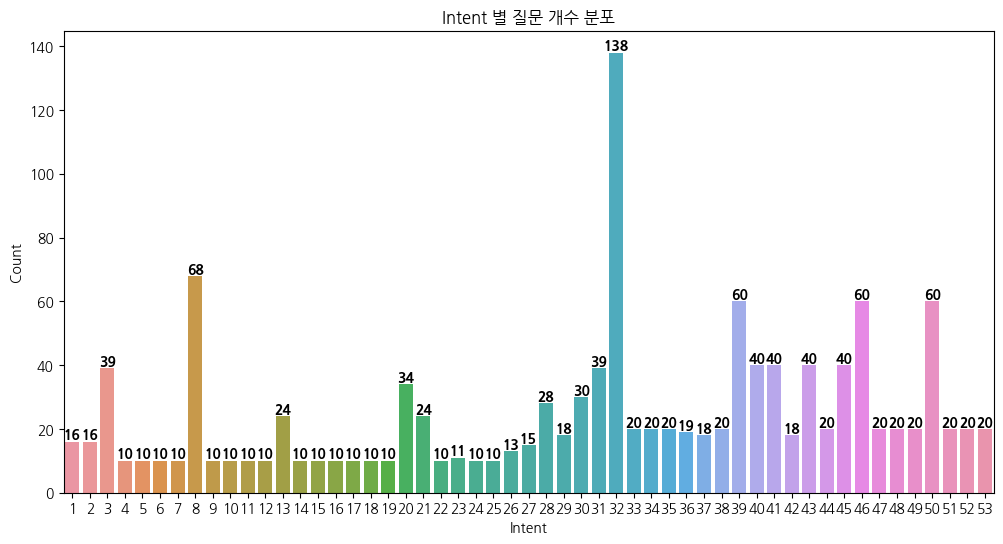

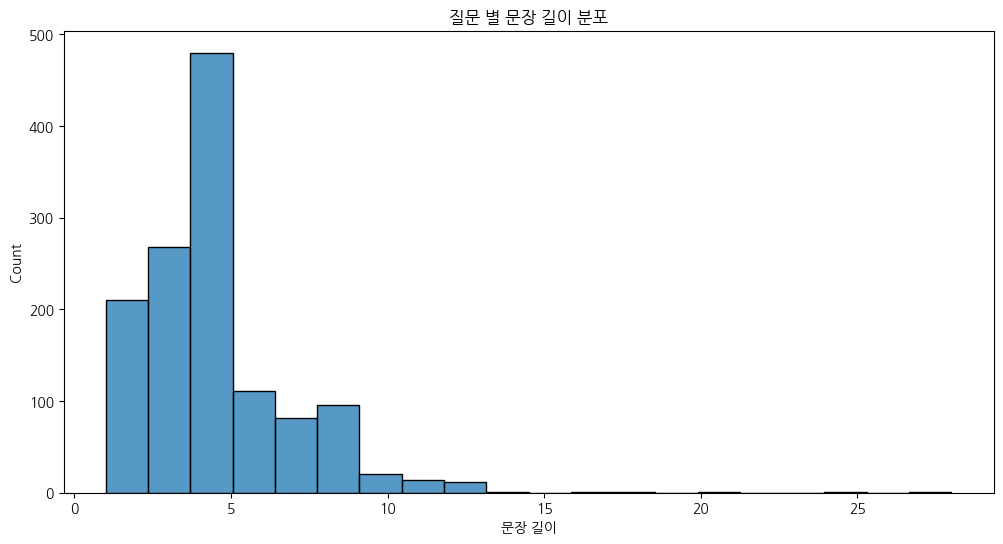

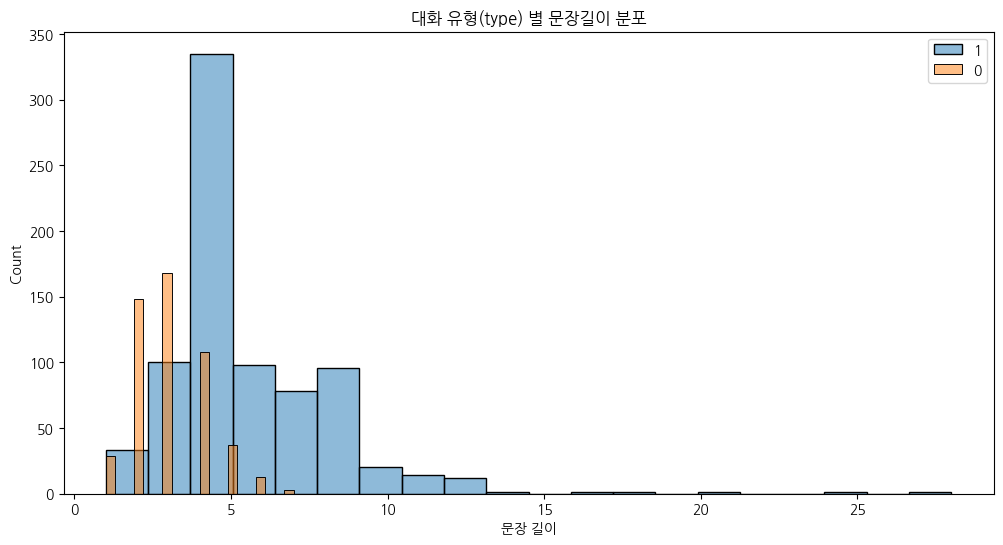

In [79]:
explore_data(merged_df)

## 3.데이터 전처리

* 세부요구사항
    * 다음 항목에 해당되는 전처리 함수를 각각 생성하여 하나로 합쳐봅시다.
        * 특수문자 제거 : 정규 표현식을 활용합니다. (띄어쓰기, \n 등)
        * 형태소 분석기 사용 : konlpy(mecab, kkma, Okt, etc), soynlp, khaiii 등 여러 형태소 분석기를 활용합니다.
    * 문장길이를 조절하여 모델 input으로 활용하기
    * joblib.dump를 이용하여 전처리 결과 데이터를 저장합니다.

### (1) 학습/평가 데이터 분리
   * test 데이터 : intent마다 무작위로 질문 2개를 뽑아 test 데이터로 분리
   * train 데이터 : 나머지 데이터


In [83]:
merged_df.drop('sentence_length', axis=1, inplace = True)

In [90]:
# intent_count = df['intent'].unique().shape[0] # 53

# train, test = train_test_split(df, test_size=intent_count*2, stratify=df['intent'], random_state=2023)

In [93]:
from sklearn.model_selection import train_test_split

df = merged_df.copy()
test = df.groupby("intent").apply(lambda x: x.sample(n=2)).reset_index(drop=True)
train = pd.concat([df, test]).drop_duplicates(keep=False)

In [94]:
test.tail()

,intent,Q,A,type
101,51,교육생으로 참여하게 되면 어떤 혜택이 있는지 궁금합니다.,"취업에 도움이 되는 다양한 프로젝트를 제공하고, 포트폴리오 작성을 도와드리며, 코딩...",1
102,52,대면 교육 시 숙소가 제공 되나요?,숙소 및 기숙사에 대한 지원은 제공하지 않습니다.,1
103,52,숙소나 기숙사가 제공 되나요?,숙소 및 기숙사에 대한 지원은 제공하지 않습니다.,1
104,53,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
105,53,KT 에이블스쿨의 특별한 점이 뭔가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1


In [95]:
train.tail()

,intent,Q,A,type
786,53,다른 국비지원과 비교할 때 차이가 뭔가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
788,53,다른 교육과의 차이점은 무엇인가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
789,53,다른 교육과 차이점이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
790,53,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
791,53,다른 교육보다 특별한 것이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1


### (2) 형태소 분석하기
- konlpy, mecab 설치 후 형태소 분석 함수 생성
    * [코랩]아래 두 코드셀을 순차적으로 실행하면 설치 됩니다.
        * 참조 : https://konlpy.org/en/latest/install/
- 형태소 분석 결과를 다음의 이름으로 생성하시오.
    - clean_train_questions
    - clean_test_questions

#### 1) 형태소 분석 패키지 설치

In [96]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.68.0-1ubuntu2.18).
git is already the newest version (1:2.25.1-1ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.8ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:9.3.0-1ubuntu2).
g++ set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Buil

In [97]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 36.1 MB/s eta 0:00:00
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  5335k      0 --:--:-- --:--:-- --:--:-- 5335k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/example.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.c
mecab-0.996-ko-0.9.2/example/example.c
mecab-0.996-ko-0.9.2/example/thread_test.cpp
mecab-0.996-ko-0.9.2/mecab-config.in
mecab-0.996-ko-0.9.2/man/
mecab-0.996-ko-0.9.2/man/Makefile.am
mecab-0.996-ko-0.9.2/man/mecab.1


#### 2) 형태소 분석을 위한 함수를 제공합니다.

In [115]:
# 1. 특수문자 제거
import re

def remove_special_chars(text):
    # 한글, 알파벳, 숫자를 제외한 모든 문자 제거
    text = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\\s]", "", text)
    # 공백을 기준으로 단어 분리
    text = " ".join(text.split())
    return text

In [106]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()
        
    return tokenizer

In [120]:
# 2. 형태소 분석기 사용
# 형태소 분석을 수행하는 함수

def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # 특수문자 제거
    sentence = remove_special_chars(original_sent)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    # sentence = original_sent.replace('\n', '').strip() # 줄바꿈 단위로 문장 판단 
    if nouns:       
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)
    
    return tokenized_sent

#### 3) 형태소 분석 테스트
* 몇개 데이터에 대해 형태소 분석 확인하기

In [118]:
train['Q'][1]

'액정 나갔어'

In [121]:
# tokenizer_names = ["komoran", "okt", "mecab", "hannanum", "kkma"]
tokenizer_names = ["mecab"]
for tokenizer_name in tokenizer_names:
    print(f"--- Tokenizer: {tokenizer_name} ---")
    for sent in train['Q']:
        tokenized_sent = tokenize(tokenizer_name, sent)
        print(f"원본 문장: {sent}")
        print(f"토큰화된 문장: {tokenized_sent}")
    print("\n")

--- Tokenizer: mecab ---
원본 문장: 떨어뜨려서 핸드폰 액정 나갔어
토큰화된 문장: 떨어뜨려서 핸드폰 액정 나갔 어
원본 문장: 액정 나갔어
토큰화된 문장: 액정 나갔 어
원본 문장: 핸드폰 떨어뜨려서 고장 났나봐
토큰화된 문장: 핸드폰 떨어뜨려서 고장 났 나 봐
원본 문장: 노트북 키보드가 안먹히네
토큰화된 문장: 노트북 키보드 가 안 먹히 네
원본 문장: 노트북 전원이 안들어와.
토큰화된 문장: 노트북 전원 이 안 들어와
원본 문장: 컴퓨터가 제대로 작동하지 않아요
토큰화된 문장: 컴퓨터 가 제대로 작동 하 지 않 아요
원본 문장: 컴퓨터가 에러 메시지를 띄우고 있어요.
토큰화된 문장: 컴퓨터 가 에러 메시지 를 띄우 고 있 어요
원본 문장: 컴터 고장났나봐
토큰화된 문장: 컴 터 고장났 나 봐
원본 문장: 컴터가 맛이 갔어
토큰화된 문장: 컴 터 가 맛 이 갔 어
원본 문장: 컴터가 안돼
토큰화된 문장: 컴 터 가 안 돼
원본 문장: 핸드폰 고장났나봐
토큰화된 문장: 핸드폰 고장났 나 봐
원본 문장: 핸드폰 맛이 갔어
토큰화된 문장: 핸드폰 맛 이 갔 어
원본 문장: 핸드폰 안돼
토큰화된 문장: 핸드폰 안 돼
원본 문장: 노트북 안돼
토큰화된 문장: 노트북 안 돼
원본 문장: 내 의지는 상관없나봐
토큰화된 문장: 내 의지 는 상관없 나 봐
원본 문장: 내 의지로 안되는 일인가봐
토큰화된 문장: 내 의 지로 안 되 는 일 인가 봐
원본 문장: 건강이 최고
토큰화된 문장: 건강 이 최고
원본 문장: 건강이 최고인 것 같아
토큰화된 문장: 건강 이 최고 인 것 같 아
원본 문장: 아프면 안 되는데
토큰화된 문장: 아프 면 안 되 는데
원본 문장: 올해도 건강하길
토큰화된 문장: 올해 도 건강 하 길
원본 문장: 올해도 행복하길
토큰화된 문장: 올해 도 행복 하 길
원본 문장: 올해 합격하길
토큰화된 문장: 올해 합격 하 길
원본 문장: 건강이 최고야
토큰화된 문장: 건강 이 최고 야
원본 문장: 이번년도는 꼭 집을 장만할거야
토큰화된 문장:

#### 4) train, test의 Q에 대해 형태소 분석하여 저장하기
* 데이터프레임의 각 행 별로 함수를 적용하는 방법
    * .apply(lambda ..........) 를 활용하면 손쉽게 처리할수 있습니다.

In [122]:
clean_train_questions = train["Q"].apply(lambda x: tokenize('mecab', x))
clean_test_questions = test["Q"].apply(lambda x: tokenize('mecab', x))
print(clean_train_questions[:10])

0            떨어뜨려서 핸드폰 액정 나갔 어
1                      액정 나갔 어
2           핸드폰 떨어뜨려서 고장 났 나 봐
4             노트북 키보드 가 안 먹히 네
5               노트북 전원 이 안 들어와
7        컴퓨터 가 제대로 작동 하 지 않 아요
8     컴퓨터 가 에러 메시지 를 띄우 고 있 어요
9                  컴 터 고장났 나 봐
10               컴 터 가 맛 이 갔 어
11                   컴 터 가 안 돼
Name: Q, dtype: object


### (3) 전처리 완료된 데이터를 파일로 저장하기
- 총 4개의 파일을 저장합니다.
    * train 셋
    * test 셋
    * 전처리된 데이터
        * clean_train_questions
        * clean_test_questions
- 저장방법
    * joblib 라이브러리를 이용하여 저장합니다.

In [123]:
import joblib

joblib.dump(train, path + 'train.pkl')
joblib.dump(test, path + 'test.pkl')
joblib.dump(clean_train_questions, path + 'clean_train_questions.pkl')
joblib.dump(clean_test_questions, path + 'clean_test_questions.pkl')

['/content/drive/MyDrive/KT aivleschool/KT_aivle_school_AI_track/16. MINI_PJ6/clean_test_questions.pkl']